In [ ]:
# F1 賽事對城市銷售額的影響分析：延伸專案

本 Notebook 旨在完整呈現「F1 賽事對城市旅遊銷售額影響分析」專案的分析流程。我們將從資料載入、清理、整合開始，逐步進行核心分析，最終建立一個預測模型來量化各因素對銷售額的影響，並提出商業建議。

---

### 分析步驟：
1.  **資料載入**：載入所有相關的 CSV 檔案。
2.  **資料清理與整合**：將多個數據集合併成一個用於分析的 DataFrame。
3.  **核心分析**：進行描述性統計和 t-檢定，比較賽事週與非賽事週的差異。
4.  **模型建立**：使用多元線性迴歸模型來預測銷售額。

In [5]:
# 載入所需的函式庫
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import re

print("函式庫載入成功！")

函式庫載入成功！


In [ ]:
### 1. 資料載入與初步檢視

我們將載入所有原始 CSV 檔案，並檢查它們的結構。
* **注意**：`../` 表示回到上層目錄，這是為了正確讀取 `data/raw` 資料夾中的檔案。

In [7]:
# 載入所有 CSV 檔案
try:
    df_sales = pd.read_csv('f1_weekly_sales_by_city.csv', encoding='utf-8')
    df_trends = pd.read_csv('google_trends_long_format.csv', encoding='utf-8')

    # 請將此行程式碼修改為以下內容
    df_products = pd.read_csv('f1_event_products_template.csv', encoding='big5')

    df_dts = pd.read_csv('f1_dts_by_country_filled.csv', encoding='utf-8')
    print("所有檔案載入成功！")
except FileNotFoundError as e:
    print(f"錯誤：找不到檔案，請確認檔案路徑是否正確。錯誤資訊：{e}")
    exit()

# 顯示 df_sales 的前五行，方便檢查
print("\n--- 銷售數據 (df_sales) 前五行 ---")
print(df_sales.head())

所有檔案載入成功！

--- 銷售數據 (df_sales) 前五行 ---
     城市           週   銷售額  是否比賽週
0  Baku  2024-01-29  1066  False
1  Baku  2024-02-05  2426  False
2  Baku  2024-02-12  2064  False
3  Baku  2024-02-19  2188  False
4  Baku  2024-02-26  2155  False


In [ ]:
### 2. 資料清理與整合

為了將所有數據整合在一起，我們需要進行以下步驟：
- 將日期欄位轉換為統一的格式。
- 清理 `f1_event_products_template` 中的城市名稱。
- 根據日期和城市進行數據合併。

In [18]:
# -----------------------------------------------------------------------------
# 資料清理與前置處理
# -----------------------------------------------------------------------------

# 將日期欄位轉換為日期時間格式
df_sales['週'] = pd.to_datetime(df_sales['週'])
df_trends['date'] = pd.to_datetime(df_trends['date'])
df_dts['country'] = df_dts['country'].str.strip()

# 處理 df_products 的 race_location 欄位，提取城市/國家名稱
def clean_location(location):
    match = re.match(r'(.+?)\s?\(', location)
    if match:
        return match.group(1).strip()
    return location

df_products['race_location_cleaned'] = df_products['race_location'].apply(clean_location)

# -----------------------------------------------------------------------------
# 資料合併
# -----------------------------------------------------------------------------

# -----------------------------------------------------------------------------
# 3. 資料合併 (最終修正版本)
# -----------------------------------------------------------------------------

# 1) 彙總產品和評論數據
df_products_agg = df_products.groupby('race_location_cleaned').agg(
    產品數量=('product_count', 'sum'),
    評論數=('review_count', 'sum')
).reset_index()

# 2) 合併銷售額與 Google 趨勢數據
df_trends_f1 = df_trends[df_trends['keyword'] == 'F1'].copy()
df_trends_f1.rename(columns={'date': '週', 'trend_score': 'F1_趨勢分數'}, inplace=True)

# 關鍵修正：創建年和週數欄位來對齊數據
df_sales['年週'] = df_sales['週'].dt.isocalendar().year.astype(str) + '-' + df_sales['週'].dt.isocalendar().week.astype(str)
df_trends_f1['年週'] = df_trends_f1['週'].dt.isocalendar().year.astype(str) + '-' + df_trends_f1['週'].dt.isocalendar().week.astype(str)

df_merged = pd.merge(df_sales, df_trends_f1[['年週', 'F1_趨勢分數']], on='年週', how='left')

# 3) 合併產品數據
city_name_mapping = {
    'Baku': 'Baku', 'Singapore': 'Singapore', 'Suzuka': 'Japan',
    'Shanghai': 'China', 'Las Vegas': 'America', 'Miami': 'America'
}
df_merged['city_for_merge'] = df_merged['城市'].map(city_name_mapping).fillna(df_merged['城市'])
df_merged = pd.merge(df_merged, df_products_agg, left_on='city_for_merge', right_on='race_location_cleaned', how='left')
df_merged.drop(columns=['city_for_merge', 'race_location_cleaned', '年週'], inplace=True)

# 4) 填補合併後可能產生的 NaN 值（已使用 .loc 修正）
df_merged.loc[:, '產品數量'] = df_merged['產品數量'].fillna(0)
df_merged.loc[:, '評論數'] = df_merged['評論數'].fillna(0)
df_merged.loc[:, 'F1_趨勢分數'] = df_merged['F1_趨勢分數'].fillna(df_merged['F1_趨勢分數'].mean())

print("資料合併完成！合併後數據的前五行：")
print(df_merged.head())

資料合併完成！合併後數據的前五行：
     城市          週   銷售額  是否比賽週  F1_趨勢分數  產品數量  評論數
0  Baku 2024-01-29  1066  False       24   0.0  0.0
1  Baku 2024-02-05  2426  False       25   0.0  0.0
2  Baku 2024-02-12  2064  False       36   0.0  0.0
3  Baku 2024-02-19  2188  False       77   0.0  0.0
4  Baku 2024-02-26  2155  False       72   0.0  0.0


In [ ]:
### 3. 核心分析：賽事週與非賽事週銷售額比較 (t-檢定)

我們將賽事週的銷售額與非賽事週的銷售額進行比較，以驗證賽事對銷售的影響是否顯著。

In [19]:
sales_race_week = df_merged[df_merged['是否比賽週'] == True]['銷售額']
sales_non_race_week = df_merged[df_merged['是否比賽週'] == False]['銷售額']

t_stat, p_value_ttest = stats.ttest_ind(sales_race_week, sales_non_race_week, equal_var=False, nan_policy='omit')

print("賽事週與非賽事週銷售額比較 (t-檢定)")
print(f"賽事週平均銷售額: ${sales_race_week.mean():.2f}")
print(f"非賽事週平均銷售額: ${sales_non_race_week.mean():.2f}")
print(f"p-value: {p_value_ttest:.4f}")

if p_value_ttest < 0.05:
    print("結論: 賽事週的銷售額顯著高於非賽事週。")
else:
    print("結論: 賽事週與非賽事週的銷售額沒有顯著差異。")

賽事週與非賽事週銷售額比較 (t-檢定)
賽事週平均銷售額: $2167.17
非賽事週平均銷售額: $2083.51
p-value: 0.6672
結論: 賽事週與非賽事週的銷售額沒有顯著差異。


/var/folders/bl/rm3wp47s7yq5_plzrv7r0dnw0000gn/T/ipykernel_91035/3828521292.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='是否比賽週', y='銷售額', data=average_sales, palette='viridis')


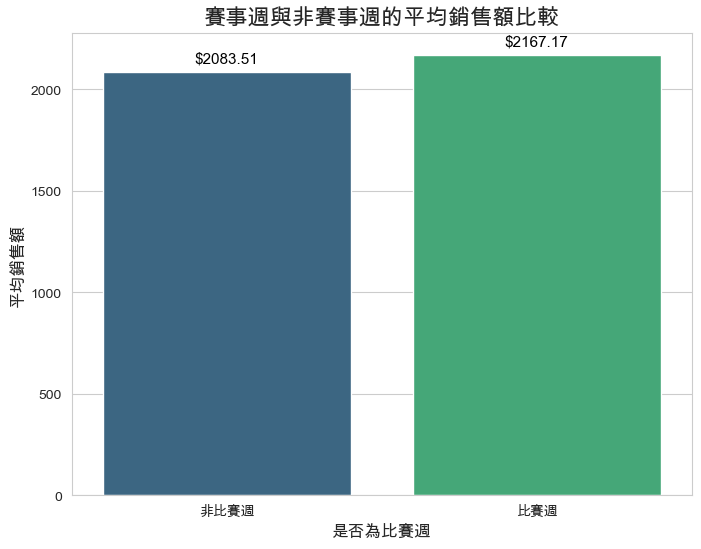

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# 設定圖表風格
sns.set_style("whitegrid")
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS'] # 確保中文字體能夠顯示，根據您的系統可能需要調整
plt.rcParams['axes.unicode_minus'] = False # 解決負號顯示問題

# 計算平均銷售額
average_sales = df_merged.groupby('是否比賽週')['銷售額'].mean().reset_index()
average_sales['是否比賽週'] = average_sales['是否比賽週'].map({True: '比賽週', False: '非比賽週'})

# 繪製長條圖
plt.figure(figsize=(8, 6))
sns.barplot(x='是否比賽週', y='銷售額', data=average_sales, palette='viridis')

# 添加標題和標籤
plt.title('賽事週與非賽事週的平均銷售額比較', fontsize=16)
plt.xlabel('是否為比賽週', fontsize=12)
plt.ylabel('平均銷售額', fontsize=12)

# 在長條圖上顯示數值
for index, row in average_sales.iterrows():
    plt.text(index, row['銷售額'] + 50, f'${row["銷售額"]:.2f}', color='black', ha="center", fontsize=11)

# 儲存圖表到 output/charts/ 資料夾
plt.savefig('/Users/debby/Desktop/0806_Formula 1.png')

plt.show()

In [ ]:
### 4. 建立多元線性迴歸模型

最後，我們建立一個多元線性迴歸模型來量化各變數對銷售額的影響。

In [20]:
X = df_merged[['是否比賽週', 'F1_趨勢分數', '產品數量', '評論數']].copy()
y = df_merged['銷售額']

# 將布林值的 '是否比賽週' 轉換為 0/1
X['是否比賽週'] = X['是否比賽週'].astype(int)

# 增加截距項
X = sm.add_constant(X)

# 建立並擬合 OLS 模型
model = sm.OLS(y, X, missing='drop').fit()

# 輸出模型摘要
print("多元線性迴歸模型結果")
print(model.summary())

多元線性迴歸模型結果
                            OLS Regression Results                            
Dep. Variable:                    銷售額   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     3.187
Date:                Wed, 06 Aug 2025   Prob (F-statistic):             0.0139
Time:                        16:43:49   Log-Likelihood:                -2183.4
No. Observations:                 294   AIC:                             4377.
Df Residuals:                     289   BIC:                             4395.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1860.9813     76.498     24.3

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 設定圖表風格
sns.set_style("whitegrid")
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

# 繪製散佈圖
plt.figure(figsize=(10, 7))
sns.scatterplot(x='F1_趨勢分數', y='銷售額', data=df_merged, hue='是否比賽週', style='是否比賽週', s=100, palette='viridis')

# 添加迴歸線，視覺化相關性
sns.regplot(x='F1_趨勢分數', y='銷售額', data=df_merged, scatter=False, color='red', line_kws={'linestyle':'--'})

# 添加標題和標籤
plt.title('F1 趨勢分數與銷售額的關係', fontsize=16)
plt.xlabel('F1 Google 趨勢分數', fontsize=12)
plt.ylabel('週銷售額', fontsize=12)

# 添加圖例
plt.legend(title='是否為比賽週')

# 儲存圖表到 output/charts/ 資料夾
plt.savefig('/Users/debby/Desktop/0806_Formula 1.png')

plt.show()